# Test FCN16s

![image.png](imgs/1.png)

In [ ]:
import os
import os.path as osp
import datetime
import shlex
import subprocess

import pytz
import torch
import yaml

import warnings
warnings.filterwarnings('ignore')

configurations = {
    # same configuration as original work
    # https://github.com/shelhamer/fcn.berkeleyvision.org
    1: dict(
        max_iteration=100000,
        lr=1.0e-10,
        momentum=0.99,
        weight_decay=0.0005,
        interval_validate=4000,
    )
}


In [ ]:
cfg = configurations[1]

In [ ]:
gpu = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
cuda = torch.cuda.is_available()

## PascalVOC Dataset

In [ ]:
import numpy as np

class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])
mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])

## FCN - Model

In [ ]:
import numpy as np
import torch.nn as nn

class FCN16s(nn.Module):

    def __init__(self, n_class=21):
        super(FCN16s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore16 = nn.ConvTranspose2d(
            n_class, n_class, 32, stride=16, bias=False)


    def forward(self, x, debug=False):
        h = x
        if debug: print(h.data.shape)
        h = self.relu1_1(self.conv1_1(h))
        if debug: print(h.data.shape)
        h = self.relu1_2(self.conv1_2(h))
        if debug: print(h.data.shape)
        h = self.pool1(h)
        if debug: print(h.data.shape)

        h = self.relu2_1(self.conv2_1(h))
        if debug: print(h.data.shape)
        h = self.relu2_2(self.conv2_2(h))
        if debug: print(h.data.shape)
        h = self.pool2(h)
        if debug: print(h.data.shape)

        h = self.relu3_1(self.conv3_1(h))
        if debug: print(h.data.shape)
        h = self.relu3_2(self.conv3_2(h))
        if debug: print(h.data.shape)
        h = self.relu3_3(self.conv3_3(h))
        if debug: print(h.data.shape)
        h = self.pool3(h)
        if debug: print(h.data.shape)

        h = self.relu4_1(self.conv4_1(h))
        if debug: print(h.data.shape)
        h = self.relu4_2(self.conv4_2(h))
        if debug: print(h.data.shape)
        h = self.relu4_3(self.conv4_3(h))
        if debug: print(h.data.shape)
        h = self.pool4(h)
        if debug: print('pool4: {}'.format(h.data.shape))
        pool4 = h  # 1/16 #<------------------------------------

        h = self.relu5_1(self.conv5_1(h))
        if debug: print(h.data.shape)
        h = self.relu5_2(self.conv5_2(h))
        if debug: print(h.data.shape)
        h = self.relu5_3(self.conv5_3(h))
        if debug: print(h.data.shape)
        h = self.pool5(h)
        if debug: print(h.data.shape)

        h = self.relu6(self.fc6(h))
        if debug: print(h.data.shape)
        h = self.drop6(h)
        if debug: print(h.data.shape)

        h = self.relu7(self.fc7(h))
        if debug: print(h.data.shape)
        h = self.drop7(h)
        if debug: print(h.data.shape)

        h = self.score_fr(h)
        if debug: print(h.data.shape)
        h = self.upscore2(h)
        if debug: print('upscore2: {}'.format(h.data.shape))
        upscore2 = h  # 1/16

        h = self.score_pool4(pool4)
        if debug: print('score_pool4: {}'.format(h.data.shape))
        h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        if debug: print('score_pool4c: {}'.format(h.data.shape))
        score_pool4c = h  # 1/16

        h = upscore2 + score_pool4c
        if debug: print('upscore2+score_pool4c: {}'.format(h.data.shape))

        h = self.upscore16(h)
        if debug: print('upscore16: {}'.format(h.data.shape))
        h = h[:, :, 27:27 + x.size()[2], 27:27 + x.size()[3]].contiguous()
        if debug: print('upscore16 rearranged: {}'.format(h.data.shape))

        return h

## Loading model

In [ ]:
model = FCN16s(n_class=21)
if cuda: model.to('cuda')
model.eval()

In [ ]:
resume = 'logs/FCN16s/checkpoint.pth.tar'
print('Loading checkpoint from: '+resume)
checkpoint = torch.load(resume)
model.load_state_dict(checkpoint['model_state_dict'])

## Running model

In [ ]:
import PIL.Image
import torch

def fileimg2model(img_file):
    img = PIL.Image.open(img_file)
    img = np.array(img, dtype=np.uint8)
    return transform(img)

def transform(img):
    img = img[:, :, ::-1]  # RGB -> BGR
    img = img.astype(np.float64)
    img -= mean_bgr
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img

def untransform(img):
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    img += mean_bgr
    img = img.astype(np.uint8)
    img = img[:, :, ::-1]
    return img

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch.autograd import Variable

def imshow_label(label_show, alpha=None):
    import matplotlib
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (0.0,0.0,0.0,1.0)
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = np.arange(0,len(class_names))
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    plt.imshow(label_show, cmap=cmap, norm=norm, alpha=alpha)
    if alpha is None:
        plt.title(str([class_names[i] for i in np.unique(label_show) if i!=0]))
        cbar = plt.colorbar(ticks=bounds)
        cbar.ax.set_yticklabels(class_names)

def run_fromfile(img_file):
    img_torch = torch.unsqueeze(fileimg2model(img_file), 0)
    if cuda: img_torch = img_torch.to('cuda')
    with torch.no_grad():
        score = model(img_torch)
        lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]

        plt.imshow(plt.imread(img_file))
        plt.show()

        plt.imshow(plt.imread(img_file), alpha=.9)
        imshow_label(lbl_pred[0], alpha=0.5)
        plt.show()      

        imshow_label(lbl_pred[0])
        plt.show()       

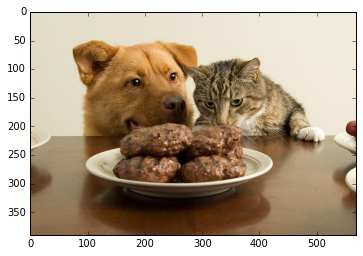

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
img_file = 'imgs/demo.jpg'
run_fromfile(img_file)

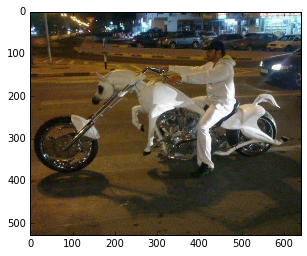

In [2]:
img_file = 'imgs/demo1.jpg'
run_fromfile(img_file)

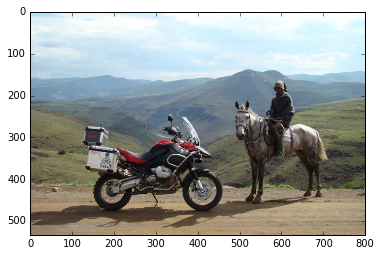

In [3]:
img_file = 'imgs/demo2.JPG'
run_fromfile(img_file)

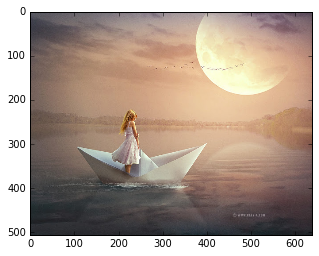

In [4]:
img_file = 'imgs/demo3.jpg'
un_fromfile(img_file)